# STYLE-ALIGNED WITH PROMPTS ONLY

In [1]:
# Clone the repository
!git clone https://github.com/alessioborgi/StyleAligned_MultiReference-MultiModal.git

# Change directory to the cloned repository
%cd StyleAligned_MultiReference-MultiModal
%ls

# Set up Git configuration
# !git config --global user.name "Alessio Borgi"
# !git config --global user.email "alessioborgi3@gmail.com"

!git config --global user.name "Name Surname"
!git config --global user.email "email@gmail.com"

# Stage the changes
#!git add .

# Commit the changes
#!git commit -m "Added some content to your-file.txt"

# Push the changes (replace 'your-token' with your actual personal access token)
#!git push origin main

Cloning into 'StyleAlignedDiffModels'...
remote: Enumerating objects: 487, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 487 (delta 21), reused 8 (delta 8), pack-reused 456
Receiving objects: 100% (487/487), 168.50 MiB | 15.31 MiB/s, done.
Resolving deltas: 100% (275/275), done.
/content/StyleAlignedDiffModels
imgs/             src/                            StyleAligned_with_Prompts_only.ipynb
LICENSE           StyleAligned_ControlNet.ipynb   StyleAligned_with_Reference.ipynb
README.md         StyleAligned_Explanation.ipynb
requirements.txt  StyleAligned_Metrics.ipynb


In [2]:
# Install the required packages
!pip install -r requirements.txt > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.1+cu121 requires torch==2.3.1, but you have torch 2.2.2 which is incompatible.
torchtext 0.18.0 requires torch>=2.3.0, but you have torch 2.2.2 which is incompatible.


In [3]:
from __future__ import annotations
import copy
import torch
import einops
import mediapy
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
from typing import Any
from typing import Callable
from dataclasses import dataclass
from diffusers.utils import load_image
from torch.nn import functional as nnf
from diffusers.models import attention_processor
from diffusers.image_processor import PipelineImageInput
from transformers import DPTImageProcessor, DPTForDepthEstimation
from diffusers.utils.torch_utils import is_compiled_module, is_torch_version
from diffusers import StableDiffusionXLPipeline, DDIMScheduler, ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL

from src.Handler import Handler
from src.StyleAlignedArgs import StyleAlignedArgs

T = torch.tensor # Create Alias for torch.tensor to increase readability.
TN = T

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
scheduler_linear = DDIMScheduler(
    beta_start=0.00085,                 # Starting value of beta
    beta_end=0.012,                     # Ending value of beta
    beta_schedule="scaled_linear",      # Type of schedule for beta values
    clip_sample=False,                  # Whether to clip samples to a specified range
    set_alpha_to_one=False,             # Whether to set alpha to one at the end of the process

    num_train_timesteps=1000,           # Number of diffusion steps used during training
    timestep_spacing="linspace",        # Method to space out timesteps
    prediction_type="epsilon",          # Type of prediction model used in the scheduler
    trained_betas=None                  # Optional pre-trained beta values
)

scheduler = scheduler_linear

In [5]:
SDXL_Pipeline = StableDiffusionXLPipeline.from_pretrained(
    pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0",  # The model name or path
    torch_dtype=torch.float16,            # Data type for the model's tensors
    variant="fp16",                       # Model variant for 16-bit floating point precision (Mixed Precision)
    use_safetensors=True,                 # Use the safetensors library for safe tensor loading
    scheduler=scheduler,                  # Scheduler instance for the diffusion process

    revision=None,                        # Model version to use, default is None
    use_auth_token=None,                  # Authentication token, None means no authentication
    cache_dir=None,                       # Directory to cache the downloaded model, None uses default
    force_download=False,                 # Force download even if the model exists locally
    resume_download=False,                # Resume a partial download if available
    proxies=None,                         # Dictionary of proxy servers to use, None means no proxies
    local_files_only=False,               # Use only local files if set to True
    device_map=None,                      # Device placement for model layers, None uses default placement
    max_memory=None                       # Maximum memory allowed for each device, None means no specific limit
).to("cuda")                              # Move the model to the GPU for faster computations

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Keyword arguments {'use_auth_token': None} are not expected by StableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
handler = Handler(SDXL_Pipeline)
sa_args = StyleAlignedArgs(share_group_norm=False,
                                      share_layer_norm=False,
                                      share_attention=True,
                                      adain_queries=True,
                                      adain_keys=True,
                                      adain_values=False
                                     )

handler.register(sa_args)

  0%|          | 0/50 [00:00<?, ?it/s]


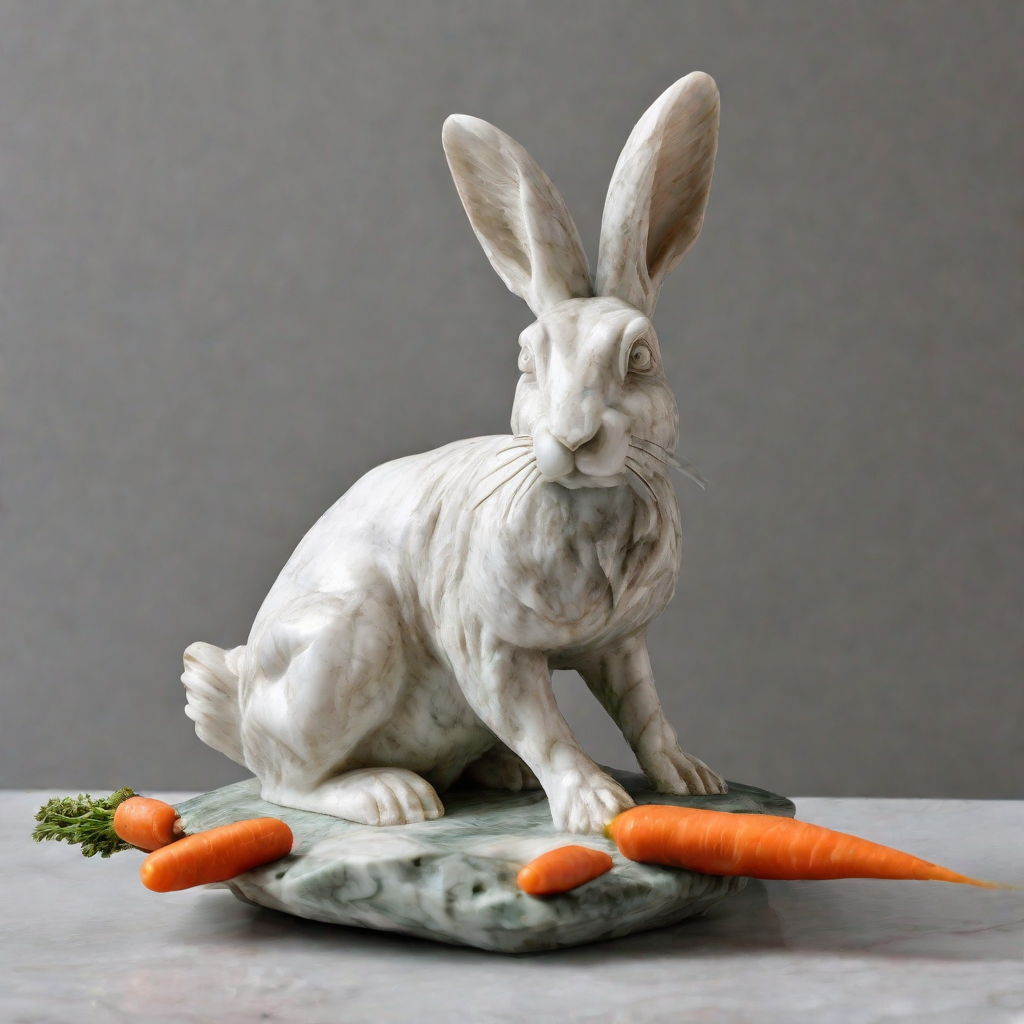
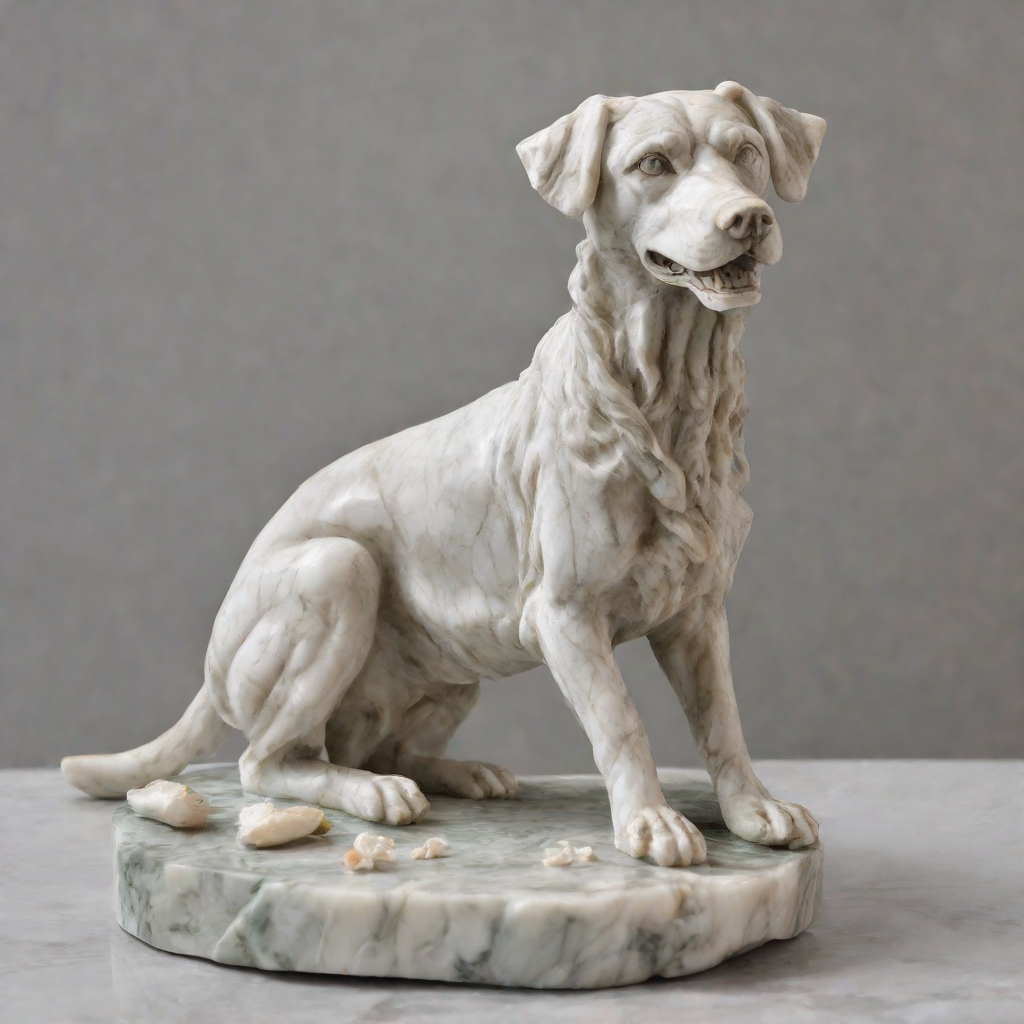
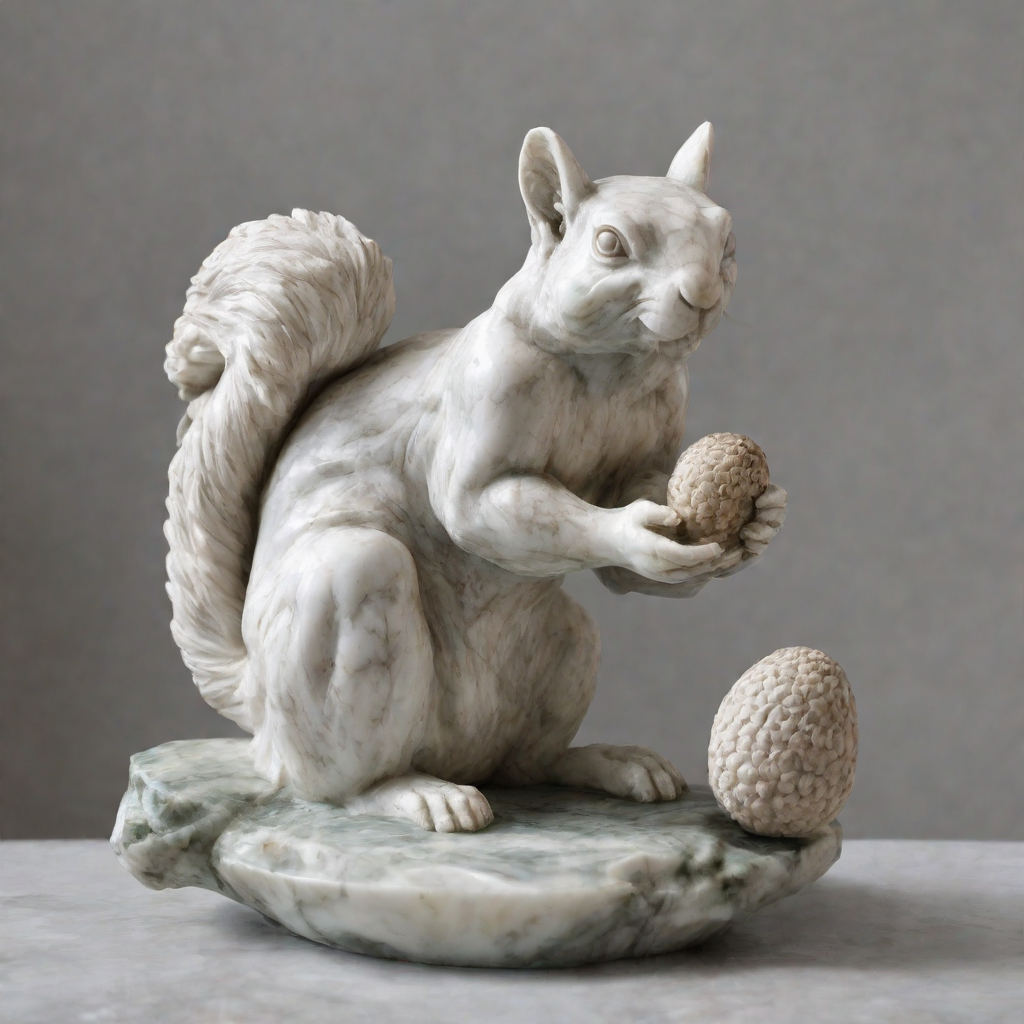
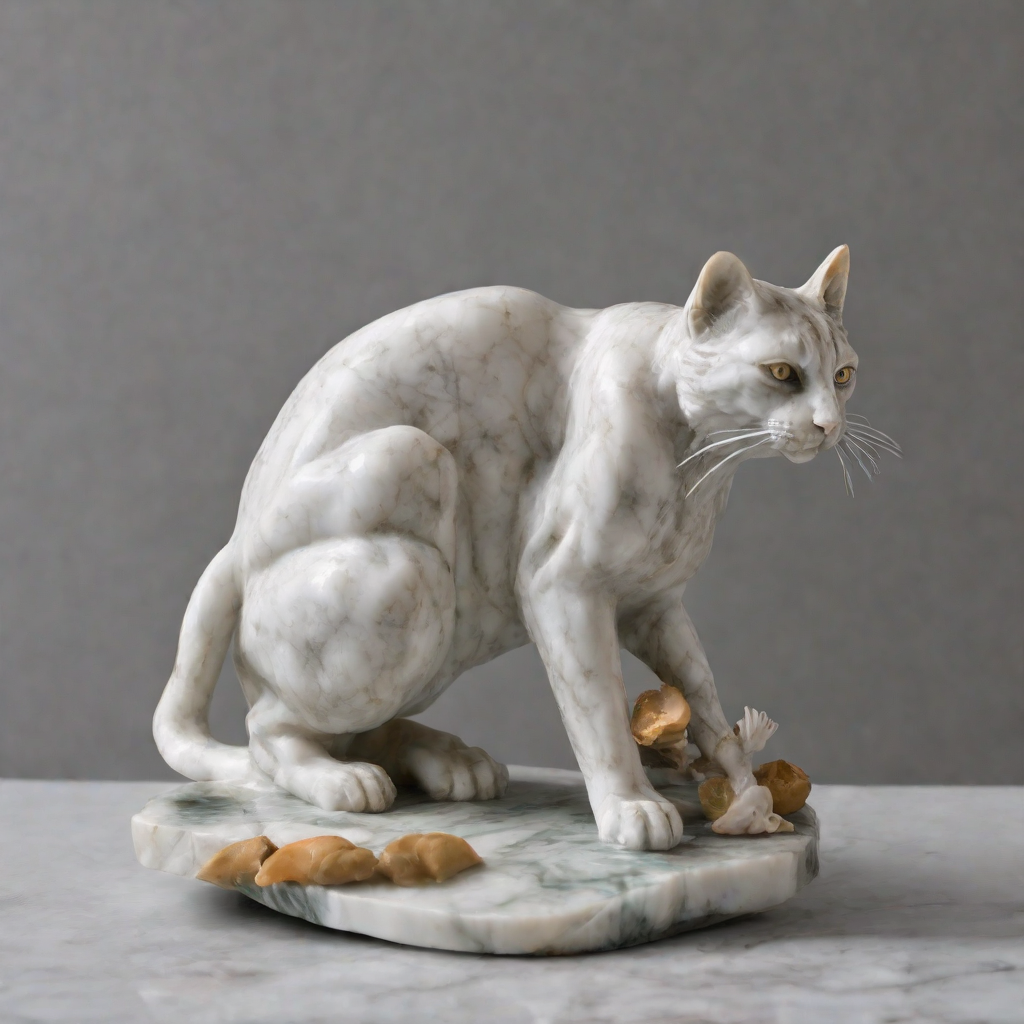

In [ ]:
# run StyleAligned

style = "marble statue"
sets_of_prompts = [
  f"A rabbit eating a carrot, {style}",
  f"A dog eating a bone, {style}",
  f"A squirrel eating an acorn, {style}",
  f"A cat eating a mouse, {style}",
]

images = SDXL_Pipeline(sets_of_prompts,).images
mediapy.show_images(images)

In [8]:
import tensorflow as tf
import torch

def clear_gpu_memory():
    # Clear TensorFlow GPU memory
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()

    # Clear PyTorch GPU memory
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    print("GPU memory cleared.")

# Execute the function to clear GPU memory
clear_gpu_memory()

GPU memory cleared.
